In [3]:
import os
import sys
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from spvelo import *
import matplotlib

In [4]:
del_adata = anndata.read_h5ad('/gpfs/gibbs/pi/zhao/wl545/spatial_velo_sorted/OSCC/regulatory/adatas/del_EGFR_prefilter_mnn_mmd.h5ad')
adata = anndata.read_h5ad('/gpfs/gibbs/pi/zhao/wl545/spatial_velo_sorted/OSCC/batch_integration/seed0/adatas/wonc_prefilter_mnn_mmd.h5ad')

In [10]:
def perturb_effect(ori_adata, del_adata, db_terms=None, batch_key='batch'):
    from sklearn.metrics.pairwise import cosine_similarity
    from gseapy import Msigdb
    msig = Msigdb()
    gmt = msig.get_gmt(category='c3.tft', dbver="2023.2.Hs")
    effect_dict = {}
    for term in db_terms:
        target = list(gmt[term])
        target = np.intersect1d(target, del_adata.var_names)
        if len(target)==0:
            continue
            
        effect_dict[term] = []
            
        for b in list(set(adata.obs[batch_key])):
            ori_velo = ori_adata[ori_adata.obs.batch==b, target].layers['velocity']
            del_velo = del_adata[del_adata.obs.batch==b, target].layers['velocity']
                
            df = pd.DataFrame(cosine_similarity(del_velo.T, ori_velo.T), index=target, columns=target)
            for i in target:
                effect_dict[term].append(df.loc[i,i])
                    
    return effect_dict

In [11]:
from gseapy import Msigdb
import random
setup_seed(0)
msig = Msigdb()
gmt = msig.get_gmt(category='c3.tft', dbver="2023.2.Hs")

[rank: 0] Global seed set to 0


In [12]:
terms = gmt.keys()
effect_dict = perturb_effect(ori_adata=adata, del_adata=del_adata, db_terms=terms)

([0, 1, 2, 3],
 [Text(0, 0, 'EGFR_target_genes'),
  Text(1, 0, 'FOXO4_target_genes'),
  Text(2, 0, 'IGLV5_37_target_genes'),
  Text(3, 0, 'GLI3_target_genes')])

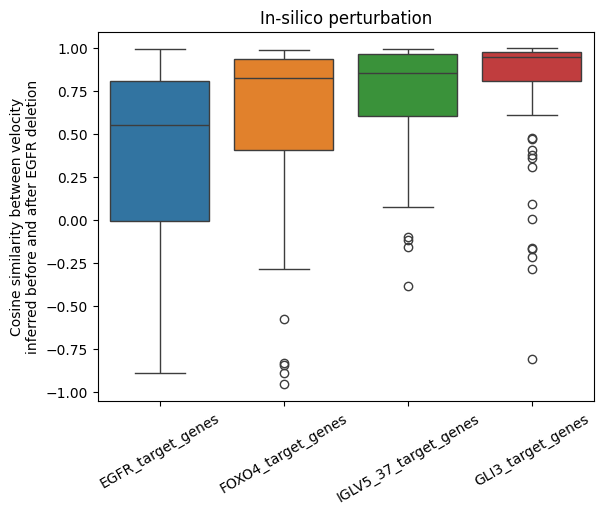

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
data = {'EGFR_target_genes': effect_dict['EGFR_TARGET_GENES'],
        'FOXO4_target_genes': effect_dict['FOXO4_TARGET_GENES'],
        'IGLV5_37_target_genes': effect_dict['IGLV5_37_TARGET_GENES'],
        'GLI3_target_genes': effect_dict['GLI3_TARGET_GENES'],
       }
sns.boxplot(data)

plt.title("In-silico perturbation")
plt.ylabel("Cosine similarity between velocity\ninferred before and after EGFR deletion")
plt.xticks(rotation=30)

In [15]:
stat1, p_value1 = ttest_ind(effect_dict['EGFR_TARGET_GENES'], effect_dict['FOXO4_TARGET_GENES'], alternative='less')
print(f"One-sided t-test p-value between EGFR_TARGET_GENES and FOXO4_TARGET_GENES: {p_value1}")
stat2, p_value2 = ttest_ind(effect_dict['EGFR_TARGET_GENES'], effect_dict['IGLV5_37_TARGET_GENES'], alternative='less')
print(f"One-sided t-test p-value between EGFR_TARGET_GENES and IGLV5_37_TARGET_GENES: {p_value2}")
stat3, p_value3 = ttest_ind(effect_dict['EGFR_TARGET_GENES'], effect_dict['GLI3_TARGET_GENES'], alternative='less')
print(f"One-sided t-test p-value between EGFR_TARGET_GENES and GLI3_TARGET_GENES: {p_value3}")

One-sided t-test p-value between EGFR_TARGET_GENES and FOXO4_TARGET_GENES: 0.018561396995869162
One-sided t-test p-value between EGFR_TARGET_GENES and IGLV5_37_TARGET_GENES: 7.039019938688176e-05
One-sided t-test p-value between EGFR_TARGET_GENES and GLI3_TARGET_GENES: 5.863590916471328e-08


In [16]:
lr_pairs = [['ECM1','ITGB4'], ['PI3','PLD2'], ['ANXA1','EGFR'], ['DCN','EGFR']]

In [17]:
def calculate_lrscore(adata, lr_pairs, spatial_threshold=30, average=False, subsample=False, ct_key="cluster_annotations"):
    import itertools
    ct_list = list(set(adata.obs[ct_key]))
    ct_pairs = list(itertools.permutations(ct_list,2))+[(ct,ct) for ct in ct_list]
    lrscore_dict = {}
    spatial_mask = pd.DataFrame(False, index=adata.obs_names, columns=adata.obs_names)
    for sample in range(1,13):
        bdata = adata[adata.obs.batch==str(sample)].copy()
        sq.gr.spatial_neighbors(bdata, n_neighs=bdata.shape[0]-1)
        sp_dist = pd.DataFrame(bdata.obsp['spatial_distances'].todense(), index=bdata.obs_names, columns=bdata.obs_names)
        spatial_mask.loc[bdata.obs_names, bdata.obs_names] = sp_dist <= spatial_threshold
    for (l,r) in lr_pairs:
        lrscore_dict[(l,r)] = {}
        if average==False: #dot product
            a = np.multiply((adata[:, l].layers['spliced'].todense() @ adata[:, r].layers['spliced'].todense().T), spatial_mask)
            for (i,j) in ct_pairs:
                cells_i = adata[adata.obs[ct_key]==i].obs_names
                cells_j = adata[adata.obs[ct_key]==j].obs_names
                
                lrscore_dict[(l,r)][(i,j)] = np.average(np.array(a.loc[cells_i, cells_j]))   
                
        elif average==True:
            raise NotImplementedError("Haven't implemented")
    return lrscore_dict

In [18]:
def permutation_test(adata, lr_pairs, permute_key='spatial', n_permutations=1000, spatial_threshold=30, average=False, subsample=False, ct_key="cluster_annotations"):
    from tqdm import tqdm
    from statsmodels.stats.multitest import fdrcorrection
    
    observed_score = calculate_lrscore(adata, lr_pairs, spatial_threshold, average, ct_key)
    
    permutation_scores = {}
    for (l, r) in lr_pairs:
        permutation_scores[(l,r)] = {}
        for (i, j) in observed_score[(l, r)].keys():
            permutation_scores[(l,r)][(i,j)] = []
    
    for _ in tqdm(range(n_permutations), desc="Running Permutations"):
        shuffled_adata = adata.copy()
        if permute_key in shuffled_adata.obsm.keys():
            np.random.shuffle(shuffled_adata.obsm[permute_key])
        elif permute_key in shuffled_adata.obs.keys():
            np.random.shuffle(shuffled_adata.obs[permute_key])
            
        permuted_score = calculate_lrscore(shuffled_adata, lr_pairs=lr_pairs, spatial_threshold=spatial_threshold, 
                                           average=average, subsample=subsample, ct_key=ct_key)
        
        for (l, r) in lr_pairs:
            for (i, j) in observed_score[(l, r)].keys():
                permutation_scores[(l,r)][(i,j)].append(permuted_score[(l,r)][(i,j)])

    pval = {}
    for (l, r) in lr_pairs:
        pval[(l,r)] = {}
        tmp_pval = []
        for (i, j) in observed_score[(l, r)].keys():
            tmp_pval.append(np.mean(permutation_scores[(l,r)][(i,j)] >= observed_score[(l,r)][(i,j)]))
            
        _, pval[(l,r)] = fdrcorrection(tmp_pval, alpha=0.05, method='indep')

    return pd.DataFrame(pval, index=observed_score[(l, r)].keys())

In [20]:
import squidpy as sq
ct_result = permutation_test(adata, lr_pairs, permute_key='cluster_annotations', n_permutations=50)

Running Permutations: 100%|██████████| 50/50 [13:43<00:00, 16.47s/it]


In [24]:
pd.DataFrame(ct_result)

ECM1    PI3 ANXA1  DCN
                       ITGB4   PLD2  EGFR EGFR
core       edge        0.000  0.000  0.00  1.0
           transitory  0.000  0.000  0.00  1.0
edge       core        1.000  1.000  1.00  1.0
           transitory  1.000  1.000  1.00  1.0
transitory core        0.108  0.000  0.51  1.0
           edge        1.000  1.000  0.00  1.0
core       core        0.000  0.000  0.00  1.0
edge       edge        1.000  1.000  1.00  0.0
transitory transitory  0.000  0.828  0.00  1.0

In [22]:
import itertools
ct_key = 'cluster_annotations'
spatial_threshold = 30
ct_list = list(set(adata.obs[ct_key]))
ct_pairs = list(itertools.permutations(ct_list,2))
spatial_mask = pd.DataFrame(False, index=adata.obs_names, columns=adata.obs_names)
for sample in range(1,13):
    bdata = adata[adata.obs.batch==str(sample)].copy()
    sq.gr.spatial_neighbors(bdata, n_neighs=bdata.shape[0]-1)
    sp_dist = pd.DataFrame(bdata.obsp['spatial_distances'].todense(), index=bdata.obs_names, columns=bdata.obs_names)
    spatial_mask.loc[bdata.obs_names, bdata.obs_names] = sp_dist <= spatial_threshold

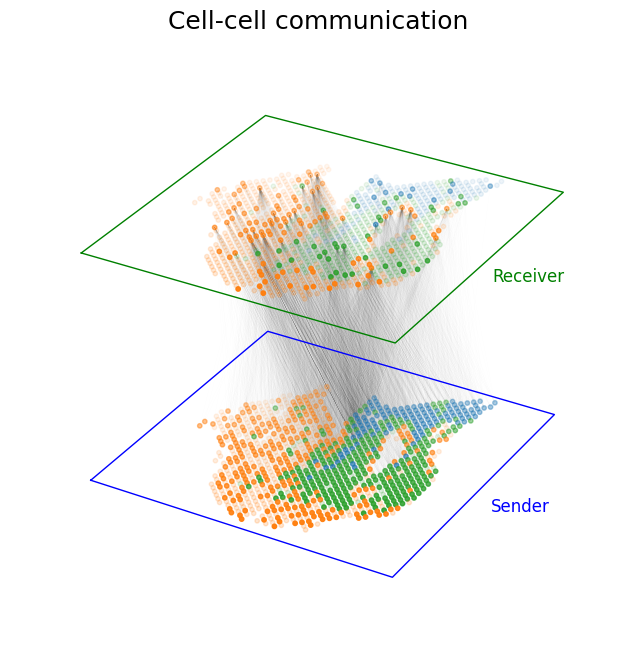

In [25]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import coo_matrix
import matplotlib.colors as mcolors
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

lr_pair = ('ANXA1','EGFR')
l,r = lr_pair
a = np.multiply((adata[:, l].layers['spliced'].todense() @ adata[:, r].layers['spliced'].todense().T), spatial_mask)
bdata = adata[adata.obs.batch=='2'].copy()
bdata.obsm['ccc'] = a.loc[bdata.obs_names, bdata.obs_names]
color_mapping = {
        'core': '#1f77b4',        # Blue color for 'core'
        'edge': '#ff7f0e',        # Orange color for 'edge'
        'transitory': '#2ca02c'   # Green color for 'transitory'
    }
bdata.obs['color_annotations'] = bdata.obs['cluster_annotations'].map(color_mapping)
x = bdata.obsm['spatial'][:,0]  # X spatial location
y = bdata.obsm['spatial'][:,1]  # Y spatial location
n_spots = bdata.shape[0]
comm_matrix = bdata.obsm['ccc'].copy()
comm_matrix[comm_matrix < np.quantile(np.array(bdata.obsm['ccc']).flatten(), 0.99)] = 0
comm_sparse = coo_matrix(comm_matrix)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the sender spots at z=0 and receiver spots at z=1
z_sender = np.zeros(n_spots)
z_receiver = np.ones(n_spots)

# Determine which spots have no connections
has_outgoing = np.array(comm_sparse.getnnz(axis=1) > 0)  # Spots with outgoing communications
has_incoming = np.array(comm_sparse.getnnz(axis=0) > 0)  # Spots with incoming communications

# Set colors
sender_colors = [mcolors.to_rgba(bdata.obs['color_annotations'][i]) if has_outgoing[i] else mcolors.to_rgba(bdata.obs['color_annotations'][i])[:3]+(0.2,) for i in range(n_spots)]
receiver_colors = [mcolors.to_rgba(bdata.obs['color_annotations'][i]) if has_incoming[i] else mcolors.to_rgba(bdata.obs['color_annotations'][i])[:3]+(0.2,) for i in range(n_spots)]
ax.scatter(x, y, z_sender, c=sender_colors, s=10, label='Sender')
ax.scatter(x, y, z_receiver, c=receiver_colors, s=10, label='Receiver')

for i, j, value in zip(comm_sparse.row, comm_sparse.col, comm_sparse.data):
    x_coords = [x[i], x[j]]
    y_coords = [y[i], y[j]]
    z_coords = [0, 1]  # From z=0 to z=1
    alpha = np.clip(value, 0, 100)
    ax.plot(x_coords, y_coords, z_coords, color='gray', alpha=alpha/3500, linewidth=0.001*alpha)

# Define the X and Y range for the frames
x_min, x_max = 10, 80
y_min, y_max = 35, 105

# Add frames for "Reference" and "Query" layers using the specified X and Y ranges
ax.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], [0, 0, 0, 0, 0], color='blue', linewidth=1)  # Reference frame
ax.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], [1, 1, 1, 1, 1], color='green', linewidth=1)  # Query frame

# Add labels for "Reference (S1)" and "Query (S4)" beside the frames
ax.text(90, 70, 0, 'Sender', ha='center', va='center', fontsize=12, color='blue')
ax.text(90, 70, 1, 'Receiver', ha='center', va='center', fontsize=12, color='green')

# Hide axis coordinates
ax.set_axis_off()

plt.title('Cell-cell communication', fontsize=18)
plt.show()

In [26]:
lr_pair = ('ANXA1','EGFR')
l,r = lr_pair
a = np.multiply((adata[:, l].layers['spliced'] @ adata[:, r].layers['velocity'].T), spatial_mask)
b = np.multiply((adata[:, l].layers['velocity'] @ adata[:, r].layers['spliced'].T), spatial_mask)

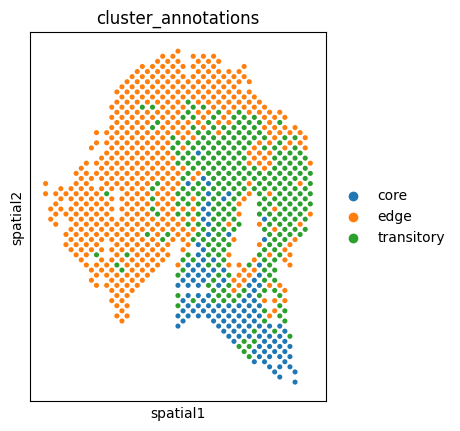

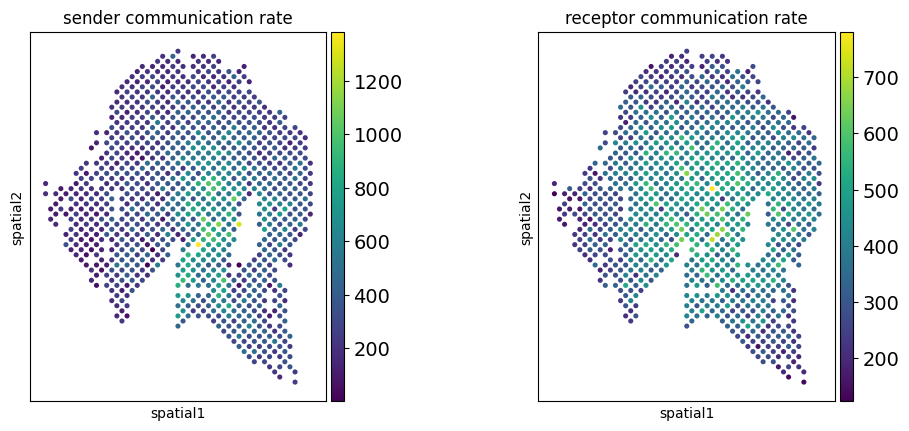

In [27]:
bdata = adata[adata.obs.batch=="2"].copy()
bdata.obsm['temporal changes in interactions'] = (a+b).loc[bdata.obs_names, bdata.obs_names]
bdata.obs['sender communication rate'] = np.sum(bdata.obsm['temporal changes in interactions'], axis=1)
bdata.obs['receptor communication rate'] = np.sum(bdata.obsm['temporal changes in interactions'], axis=0)
sc.pl.spatial(bdata, color=['cluster_annotations'], spot_size=1)
sc.pl.spatial(bdata, color=['sender communication rate', 'receptor communication rate'], spot_size=1, wspace=0)